# Mean-field Variational Inference for a Mixture of Gaussians

We implement mean-field variational inference for detecting the centers of a specified number of clusters based on a Gaussian mixture model. Work done by Rachel Levanger for Fall 2016 Foundation of Graphical Models at Columbia University, HW #3.

In [1]:
import math
import numpy as np
from scipy.stats import multivariate_normal
import pandas as pd
from scipy import misc
from scipy import spatial

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Import the dataset

We use the feature vectors generated from the topological data from the mid-plane temperature field of Rayleigh-Benard Convection.

In [2]:
sDir = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2016_11_01_superfast/g21flow'
sFeatures = 'feature_vectors_test/%06d.txt'
sTemperature = 'bmps/%06d.bmp'



In [9]:
allFeatures = []

sDir = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2016_11_01_superfast/g21flow'
sFeatures = 'feature_vectors_test/%06d.txt'
sTemperature = 'bmps/%06d.bmp'

for idx in range(1000, 2000):
    features = pd.read_csv(sDir + "/" + (sFeatures % idx), sep=' ', header=None)
    features = np.asarray(features)
    features = np.hstack((np.ones((features.shape[0],1))*idx, features))
    if len(allFeatures) == 0:
        allFeatures = features
    else:
        allFeatures = np.append(allFeatures, features, axis=0)
        
sDir = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2016_11_01_superfast/g21flow_4000'
sFeatures = 'feature_vectors_test/%06d.txt'
sTemperature = 'bmps/%06d.bmp'


for idx in range(4000, 5000):
    features = pd.read_csv(sDir + "/" + (sFeatures % idx), sep=' ', header=None)
    features = np.asarray(features)
    features = np.hstack((np.ones((features.shape[0],1))*idx, features))
    if len(allFeatures) == 0:
        allFeatures = features
    else:
        allFeatures = np.append(allFeatures, features, axis=0)
        


print allFeatures.shape
print allFeatures[0,:]
np.set_printoptions(suppress=True)
print np.amax(allFeatures,axis=0)

(213550, 113)
[ 1000.     0.    -1.    -1.   153.   320.     1.     0.     0.     0.
     0.     0.     0.     0.     9.   111.    46.    17.     0.     0.
     0.     0.     0.     0.     0.     0.     0.    11.    37.    24.
    36.     6.     0.     0.     0.     0.     0.     0.     0.     0.
     0.    53.    14.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.    65.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     2.     6.     2.    11.    16.     8.
    12.    24.    26.    24.    32.    30.    12.    10.    18.    51.
    53.    52.    19.     0.     0.     0.     0.     2.     5.     8.
    90.    90.    26.     0.     0.     0.     0.     0.     0.     0.
     0.    30.     0.     0.     0.     0.     0.     0.     0.     0.
     0.    68.   124.]
[ 4999.   152.   152.     5.   390.   390.     1.     1.     1.     1.
     1.     1.     0.     0.    18.   365.   255.    66.    65.    66.
    62.    62.    66.    66.    66.    5

In [10]:

myFeatures = np.hstack((allFeatures[:, [0,4,5]], allFeatures[:,16:]))

X = myFeatures
X = X[:,3:]
X[:,0] = X[:,0]*10
print myFeatures[0,:]
print X[0,:]
# X = myFeatures[:, featureStart:]
# X = np.hstack((X[:,0:32],X[:,32:]/1.))

print X.shape

[ 1000.   153.   320.   460.    17.     0.     0.     0.     0.     0.
     0.     0.     0.     0.    11.    37.    24.    36.     6.     0.
     0.     0.     0.     0.     0.     0.     0.     0.    53.    14.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    65.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     2.     6.     2.    11.    16.     8.    12.    24.    26.
    24.    32.    30.    12.    10.    18.    51.    53.    52.    19.
     0.     0.     0.     0.     2.     5.     8.    90.    90.    26.
     0.     0.     0.     0.     0.     0.     0.     0.    30.     0.
     0.     0.     0.     0.     0.     0.     0.     0.    68.   124.]
[ 460.   17.    0.    0.    0.    0.    0.    0.    0.    0.    0.   11.
   37.   24.   36.    6.    0.    0.    0.    0.    0.    0.    0.    0.
    0.   53.   14.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.   65.    0.    0.    0.    0.    0.    0.    0.    0.    0.    

In [33]:
N = X.shape[0]
dim = X.shape[1]

print X[0,:]
print X.shape

u, indices = np.unique(X, return_index=True)
print u


[ 460.   17.    0.    0.    0.    0.    0.    0.    0.    0.    0.   11.
   37.   24.   36.    6.    0.    0.    0.    0.    0.    0.    0.    0.
    0.   53.   14.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.   65.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    2.    6.    2.   11.   16.    8.   12.   24.   26.   24.   32.   30.
   12.   10.   18.   51.   53.   52.   19.    0.    0.    0.    0.    2.
    5.    8.   90.   90.   26.    0.    0.    0.    0.    0.    0.    0.
    0.   30.    0.    0.    0.    0.    0.    0.    0.    0.    0.   68.
  124.]
(213550, 97)
[    0.     1.     2.     3.     4.     5.     6.     7.     8.     9.
    10.    11.    12.    13.    14.    15.    16.    17.    18.    19.
    20.    21.    22.    23.    24.    25.    26.    27.    28.    29.
    30.    31.    32.    33.    34.    35.    36.    37.    38.    39.
    40.    41.    42.    43.    44.    45.    46.    47.    48.    49.
    50.    51.    52.    53.    54.    5

## Bin the data

In [67]:
a = X.astype(np.int)/100

b = np.ascontiguousarray(a).view(np.dtype((np.void, a.dtype.itemsize * a.shape[1])))
_, idx = np.unique(b, return_index=True)

unique_a = a[idx]

unique_a.shape

(13264, 97)

## View all pictures that output a certain feature vector

In [45]:
x = X[213235,:]

print sum(np.all(X==x,axis=1))

print X.shape

1
(213550, 97)


## Plot a projection of the data

(400.0, 1300.0, 0.0, 70.0)

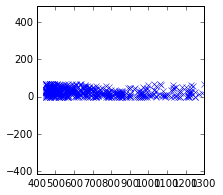

In [42]:
# Plot the means
plt.rcParams['figure.figsize'] = (3.0, 3.0)
plt.plot(X[:,0], X[:,1], 'x', markerfacecolor='blue')
plt.axis('equal')

## Plot the results!

In [20]:
# Get the expectations of the categories for each data point
z = np.zeros(N)

for n in range(N):
#     z[n] = np.random.multinomial(1,vi_phi[iterations-1,n,:]).nonzero()[0][0]
    z[n] = np.argmax(vi_phi[iterations-1,n,:])
    
z = z.astype(np.int)


(400.0, 1300.0, 0.0, 70.0)

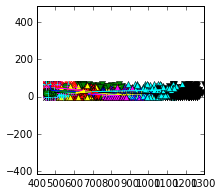

In [21]:
plt.rcParams['figure.figsize'] = (3.0, 3.0)

fig,ax = plt.subplots(1)
ax.set_aspect('equal')

color=['cyan', 'blue', 'magenta', 'green', 'red', 'yellow', 'black']
marker=['o','x','+','v','^']


# Plot the datapoints with color chosen according to variational distribution
for n in range(N):
    ax.plot(X[n,0], X[n,1], 'x', marker=marker[z[n] % len(marker)], color=color[z[n] % len(color)])

# Plot the mean history for the variational inference algorithm
for k in range(K):
    ax.plot(vi_m[:,k,0],vi_m[:,k,1], color=color[k % len(color)])
    circle = matplotlib.patches.Ellipse([vi_m[iterations-1,k,0], vi_m[iterations-1,k,1]], 2.*np.sqrt(vi_s_2[iterations-1,k]), 2.*np.sqrt(vi_s_2[iterations-1,k]), alpha=0.25, color=color[k % len(color)])
    ax.add_patch(circle)

ax.axis('equal')


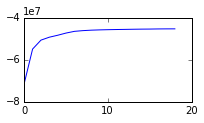

In [22]:
plt.rcParams['figure.figsize'] = (3.0, 1.5)
plt.plot(ELBO[:])
plt.locator_params(nbins=3)
# plt.savefig('/Users/birdbrain/Documents/School/Columbia/GraphicalModels/Project/writeup/figures/%d/elbo.png' % (d), bbox_inches = 'tight', pad_inches = 0)


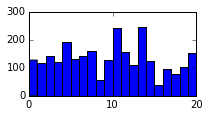

In [23]:
plt.rcParams['figure.figsize'] = (3.0, 1.5)
plt.hist(z, range(K+1))
plt.locator_params(nbins=3)
# plt.savefig('/Users/birdbrain/Documents/School/Columbia/GraphicalModels/Project/writeup/figures/%d/hist.png' % (d), bbox_inches = 'tight', pad_inches = 0)


Cluster 1


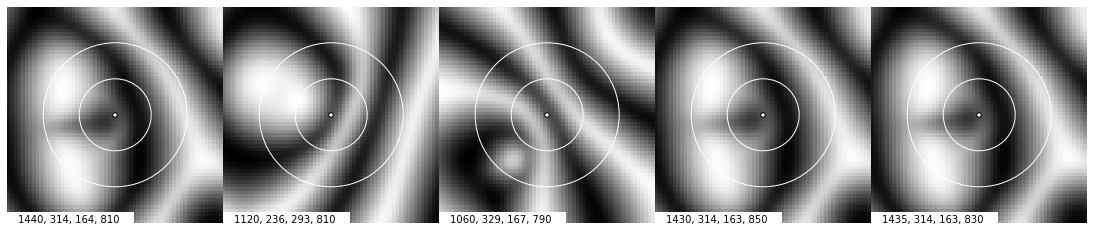

Cluster 2


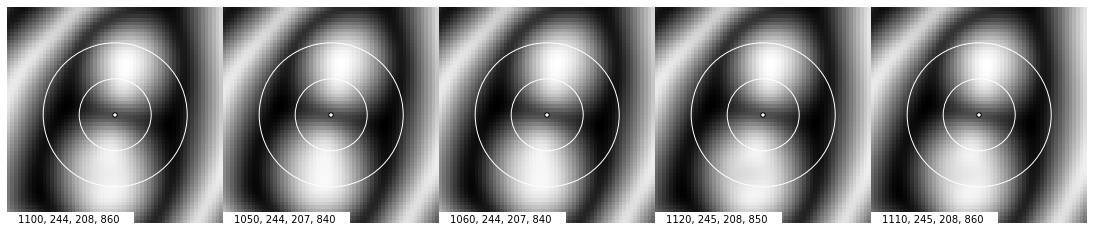

Cluster 3


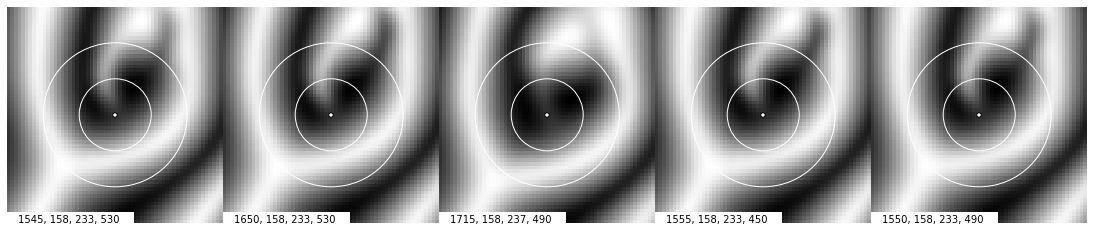

Cluster 4


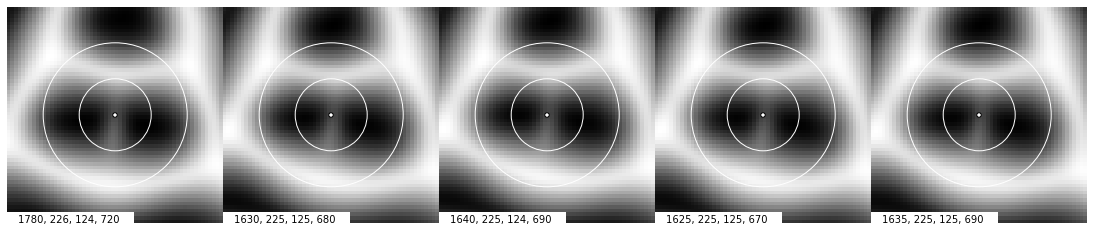

Cluster 5


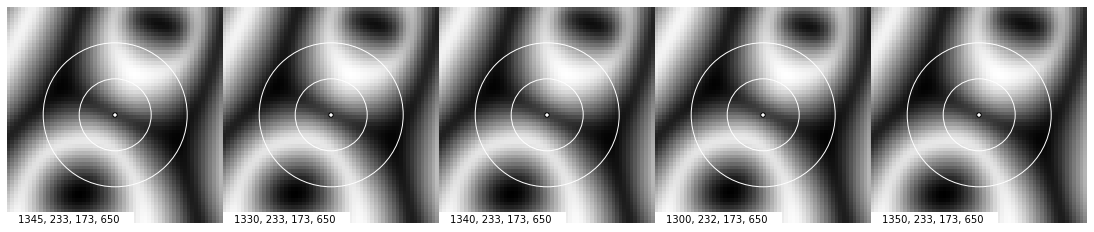

Cluster 6


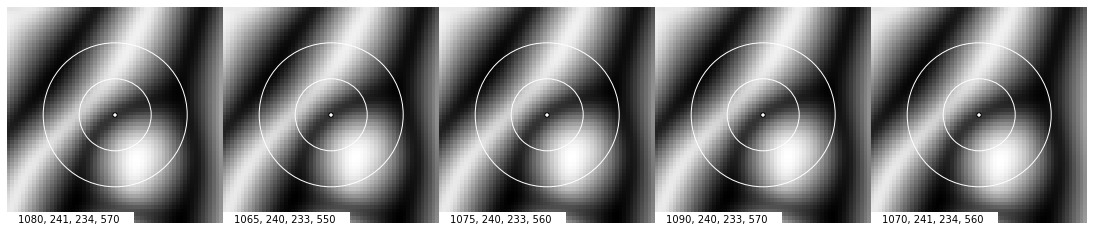

Cluster 7


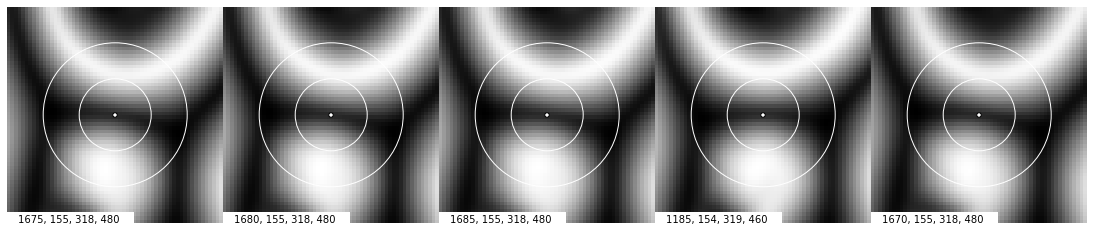

Cluster 8


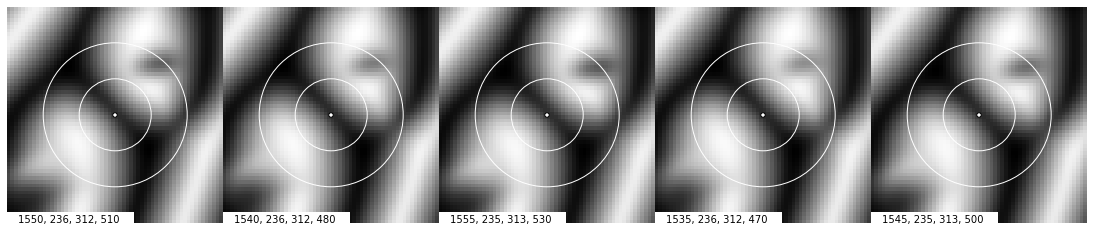

Cluster 9


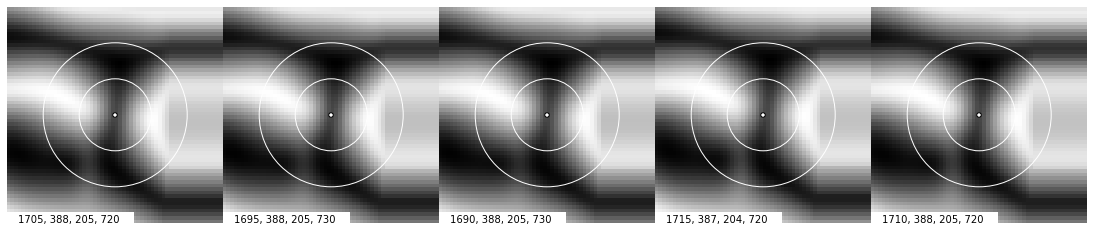

Cluster 10


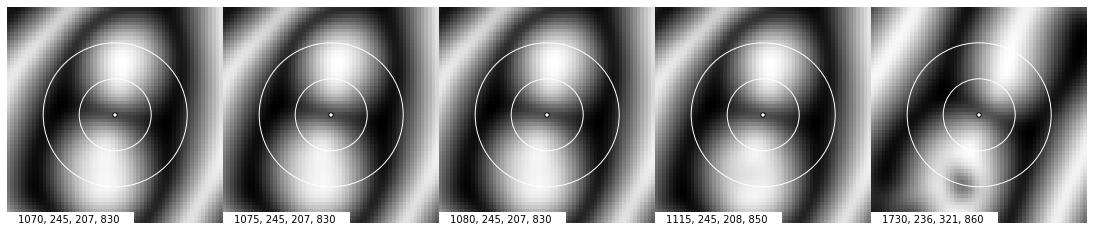

Cluster 11


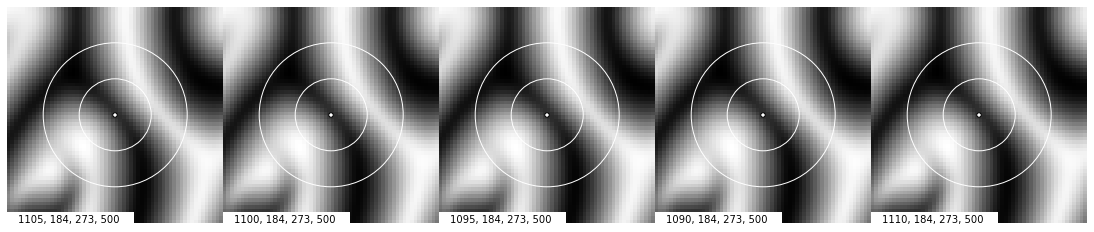

Cluster 12


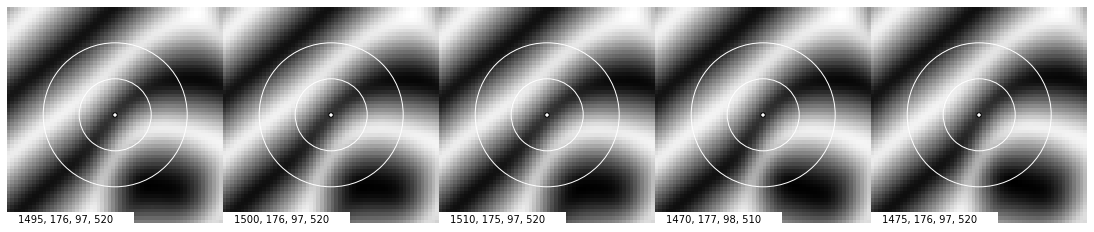

Cluster 13


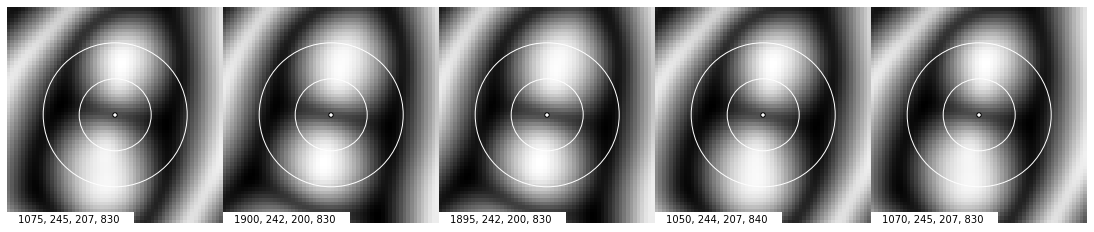

Cluster 14


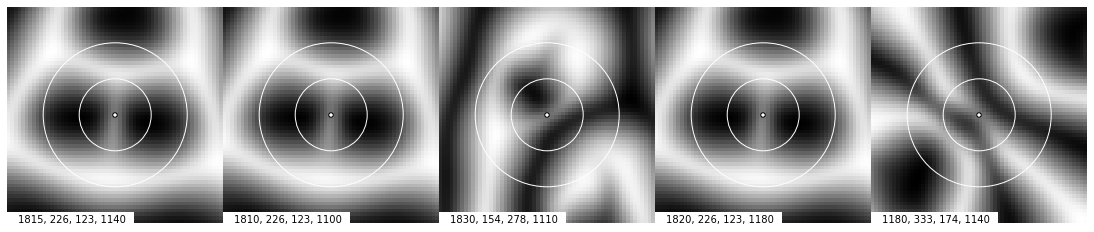

Cluster 15


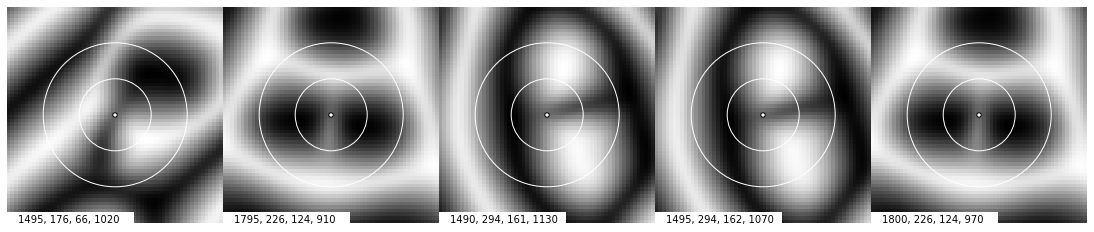

Cluster 16


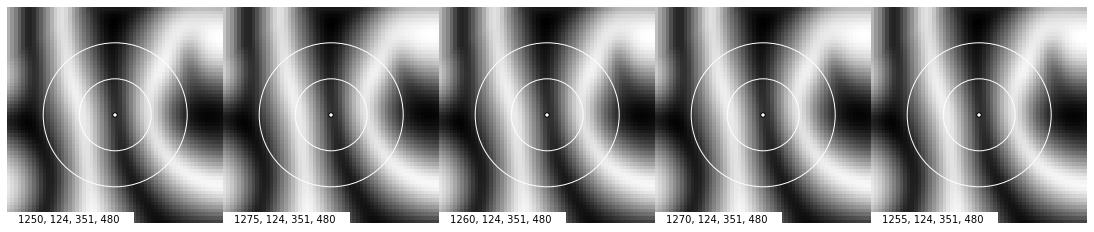

Cluster 17


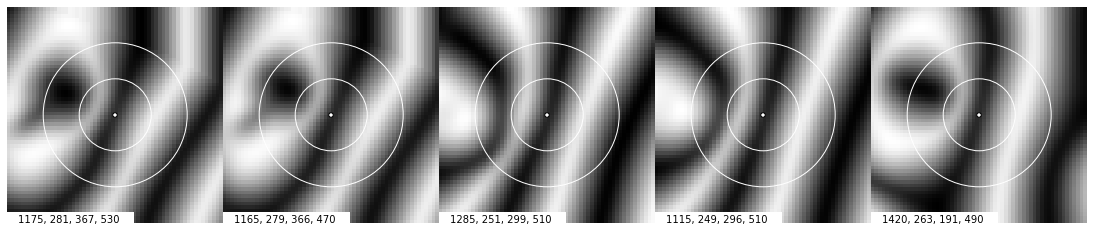

Cluster 18


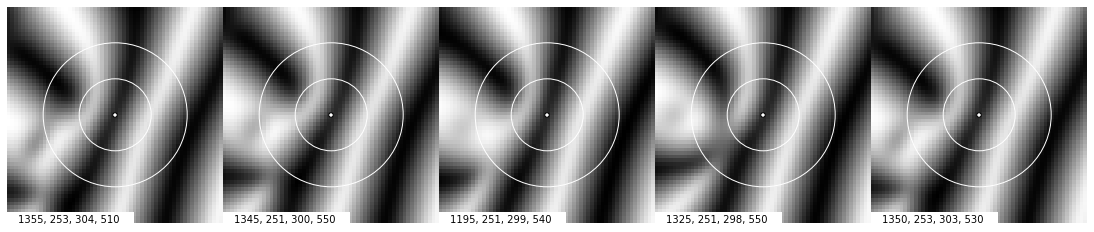

Cluster 19


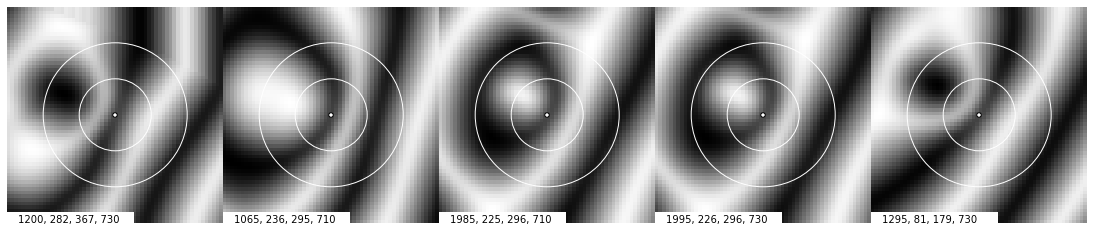

Cluster 20


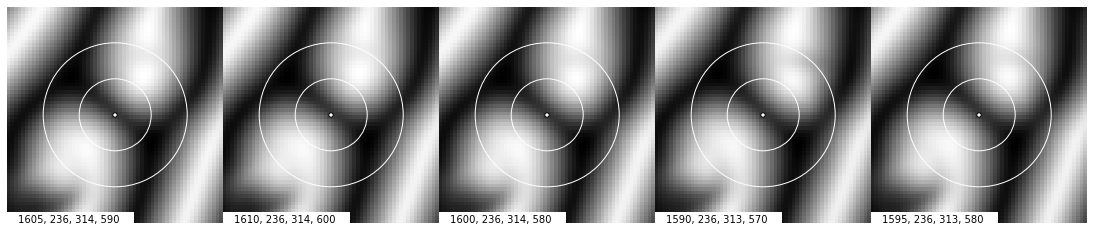

In [24]:
n = 5

plt.rcParams['figure.figsize'] = (15.0, 3.0)

for k in range(K):
    
    
    samples = myFeatures[np.argwhere(z==k),0:4]
    samples = samples.reshape((samples.shape[0],4))
        
    if len(samples) > 0:

        # Get n samples from cluster k that are closest to the mean of that cluster
        m_k = vi_m[-1,k]
        
#         if m_k[0] > 100:

#             print 'Cluster %d, LyapValue=%d' % (k+1, m_k[0])
        print 'Cluster %d' % (k+1)

        features = np.reshape(myFeatures[np.argwhere(z==k),3:], (myFeatures[np.argwhere(z==k),3:].shape[0], myFeatures[np.argwhere(z==k),3:].shape[2]))
        tree = spatial.KDTree(features)

        n_neighbors = min(n, features.shape[0])
        nn = tree.query(m_k, n_neighbors)

        for i in range(n_neighbors):

            if len(samples)==1:
                sample = nn[1]
            else:
                sample = nn[1][i]

            radius = 30
            tmp_radius = radius

            x = samples[sample,1]
            y = samples[sample,2]

            temp = misc.imread(sDir + "/" + (sTemperature % samples[sample,0]))

            plt.subplot(1,n,i)
#             fig = plt.figure()
            plt.set_cmap('gray')
            plt.pcolor(temp[(y-radius):(y+radius), (x-radius):(x+radius)].astype(np.int))
            plt.scatter(radius, radius, color='white', edgecolor='black')
            plt.gca().set_axis_off()
            plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)
            plt.margins(0,0)

#             plt.plot([tmp_radius - tmp_radius/3., tmp_radius + tmp_radius/3.], [tmp_radius, tmp_radius], color='white', lw=1)
#             plt.plot([tmp_radius, tmp_radius], [tmp_radius - tmp_radius/3., tmp_radius + tmp_radius/3.], color='white', lw=1)
            ax = plt.gca()
            circle1 = plt.Circle((tmp_radius, tmp_radius), 20, color='white', fill=False, lw=1)
            ax.add_artist(circle1)

            circle2 = plt.Circle((tmp_radius, tmp_radius), 10, color='white', fill=False, lw=1)
            ax.add_artist(circle2)

            plt.fill([0,radius+5,radius+5,0], [0,0,3,3], color='white')
            plt.annotate(', '.join([str(int(x)) for x in samples[sample,0:4]]),(3,0))

            plt.gca().xaxis.set_major_locator(plt.NullLocator())
            plt.gca().yaxis.set_major_locator(plt.NullLocator())

            plt.axis('off')

#             fig.tight_layout()
#             plt.savefig('/Users/birdbrain/Documents/School/Rutgers/Dissertation/figures/sdc/%d/%d_%d.png' % (d, k+1, i+1), bbox_inches = 'tight', pad_inches = 0)


        plt.show()